In [1]:
import collections
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Reshape, Conv2DTranspose
import numpy_datasets
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

Lead the MNIST dataset. We only need the X data, because the GAN doesn't care about labels. Its objective is solely to learn how to generate a convincing image.

In [3]:
(trainX, _), (_, _) = load_data()

We're simulating federated learning, so we split the data into 5 "clients". We pretend that the data originated from 5 different edge devices.

This is consistent with the FedGAN paper, which used a similar procedure to construct 5 "clients".

In [4]:
MNIST_SIZE = 60000
client_datasets = []
for i in range(5):
    client_ds = trainX[i * 12000: (i+1) * 12000, :, :]
    client_ds = client_ds.astype('float32')
    client_ds = client_ds / 255.0
    client_ds = np.expand_dims(client_ds, -1)
    client_datasets.append(client_ds)

Here I am simply displaying an example of what the images in the dataset look like:

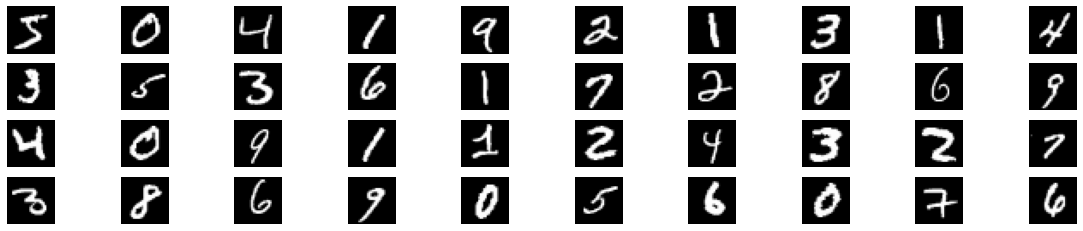

In [6]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for img in client_datasets[0][0:40,:]:
    plt.subplot(4, 10, j+1)
    plt.imshow(img, cmap='gray', aspect='equal')
    plt.axis('off')
    j += 1

The GAN code below is heavily based on the following tutorial: 

https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [7]:
# define the standalone discriminator model
def build_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

def build_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Every 30 batches, we udpate the "central model" with the average of all client models. Then, the central model is forwarded to each client model, and computation resumes. 

In [60]:
# train the generator and discriminator
def train(client_models, central_model, client_datasets, latent_dim, num_clients, n_epochs=250, n_batch=128, sync_interval=30):
    bat_per_epo = int(client_datasets[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    batch_counter = 0
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            for k in range(num_clients):
                # get randomly selected 'real' samples
                X_real, y_real = generate_real_samples(client_datasets[k], half_batch)
                # generate 'fake' examples
                X_fake, y_fake = generate_fake_samples(client_models[k]['g'], latent_dim, half_batch)
                # create training set for the discriminator
                X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
                # update discriminator model weights
                d_loss, _ = client_models[k]['d'].train_on_batch(X, y)
                # prepare points in latent space as input for the generator
                X_gan = generate_latent_points(latent_dim, n_batch)
                # create inverted labels for the fake samples
                y_gan = np.ones((n_batch, 1))
                # update the generator via the discriminator's error
                g_loss = client_models[k]['gan'].train_on_batch(X_gan, y_gan)
                # summarize loss on this batch
                
            batch_counter+=1
            if batch_counter==sync_interval:
                batch_counter = 0
                generators = [model['g'] for model in client_models]
                g_weights = [g.get_weights() for g in generators]
                new_g_weights = list()
                for g_weights_tuple in zip(*g_weights):
                    new_g_weights.append(
                        np.array([np.array(w).mean(axis=0) for w in zip(*g_weights_tuple)])
                    )
                central_model['g'].set_weights(new_g_weights)

                discriminators = [model['d'] for model in client_models]
                d_weights = [d.get_weights() for d in discriminators]
                new_d_weights = list()
                for d_weights_tuple in zip(*d_weights):
                    new_d_weights.append(
                        np.array([np.array(w).mean(axis=0) for w in zip(*d_weights_tuple)])
                    )
                central_model['d'].set_weights(new_d_weights)
                
                for k in range(num_clients):
                    client_models[k]['g'].set_weights(central_model['g'].get_weights())
                    client_models[k]['d'].set_weights(central_model['d'].get_weights())
            
            
        print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

In [61]:
# size of the latent space
latent_dim = 100
num_clients = 5

central_g = build_generator(latent_dim)
central_d = build_discriminator()
central_model = {
    "d": central_d,
    "g": central_g
}

client_models = []

for i in range(5):

    # create the discriminator
    d_model = build_discriminator()
    # create the generator
    g_model = build_generator(latent_dim)
    # create the gan
    gan_model = define_gan(g_model, d_model)
    client_models.append({
        "d": d_model,
        "g": g_model,
        "gan": gan_model
    })

# train model
train(client_models, central_model, client_datasets, latent_dim, num_clients = 5)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, 93/93, d=0.692, g=0.730
>2, 93/93, d=0.671, g=0.688
>3, 93/93, d=0.728, g=0.681
>4, 93/93, d=0.708, g=0.687
>5, 93/93, d=0.696, g=0.691
>6, 93/93, d=0.692, g=0.716
>7, 93/93, d=0.689, g=0.697
>8, 93/93, d=0.675, g=0.726
>9, 93/93, d=0.662, g=0.710
>10, 93/93, d=0.663, g=0.711
>11, 93/93, d=0.682, g=0.749
>12, 93/93, d=0.687, g=0.718
>13, 93/93, d=0.684, g=0.700
>14, 93/93, d=0.684, g=0.686
>15, 93/93, d=0.686, g=0.735
>16, 93/93, d=0.681, g=0.725
>17, 93/93, d=0.693, g=0.688
>18, 93/93, d=0.682, g=0.716
>19, 93/93, d=0.696, g=0.731
>20, 93/93, d=0.706, g=0.709
>21, 93/93, d=0.687, g=0.732
>22, 93/93, d=0.681, g=0.718
>23, 93/93, d=0.691, g=0.679
>24, 93/93, d=0.686, g=0.700
>25, 93/93, d=0.701, g=0.693
>26, 93/93, d=0.694, g=0.684
>27, 93/93, d=0.686, g=0.670
>28, 93/93, d=0.693, g=0.730
>29, 93/93, d=0.688, g=0.712
>35, 93/93, d=0.682, g=0.735
>36, 93/93, d=0.691, g=0.724
>37, 93/93, d=0.695, g=0.674
>38, 93/93, d=0.678, g=0.690
>39, 93/93, d=0.686, g=0.659
>40, 93/93, d=0.689, g=

2022-05-07 17:47:51.328313: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


>180, 93/93, d=0.687, g=0.681
>181, 93/93, d=0.690, g=0.711
>182, 93/93, d=0.688, g=0.718
>183, 93/93, d=0.684, g=0.703
>184, 93/93, d=0.689, g=0.698
>185, 93/93, d=0.692, g=0.722
>186, 93/93, d=0.684, g=0.694
>187, 93/93, d=0.693, g=0.686
>188, 93/93, d=0.694, g=0.704
>189, 93/93, d=0.691, g=0.695
>190, 93/93, d=0.694, g=0.684
>191, 93/93, d=0.687, g=0.687
>192, 93/93, d=0.690, g=0.723
>193, 93/93, d=0.701, g=0.691
>194, 93/93, d=0.700, g=0.680
>195, 93/93, d=0.689, g=0.688
>196, 93/93, d=0.690, g=0.675
>197, 93/93, d=0.693, g=0.680
>198, 93/93, d=0.695, g=0.676
>199, 93/93, d=0.691, g=0.697
>200, 93/93, d=0.691, g=0.689
>201, 93/93, d=0.696, g=0.694
>202, 93/93, d=0.695, g=0.721
>203, 93/93, d=0.695, g=0.690
>204, 93/93, d=0.691, g=0.701
>205, 93/93, d=0.688, g=0.704
>206, 93/93, d=0.694, g=0.708
>207, 93/93, d=0.686, g=0.700
>208, 93/93, d=0.697, g=0.712
>209, 93/93, d=0.695, g=0.730
>210, 93/93, d=0.689, g=0.708
>211, 93/93, d=0.702, g=0.699
>212, 93/93, d=0.692, g=0.689
>213, 93/9

2022-05-07 18:10:31.028042: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


>224, 93/93, d=0.691, g=0.698
>225, 93/93, d=0.694, g=0.688
>226, 93/93, d=0.696, g=0.694
>227, 93/93, d=0.691, g=0.681
>228, 93/93, d=0.695, g=0.715
>229, 93/93, d=0.688, g=0.702
>230, 93/93, d=0.691, g=0.703
>231, 93/93, d=0.691, g=0.688
>232, 93/93, d=0.689, g=0.684
>233, 93/93, d=0.694, g=0.700
>234, 93/93, d=0.697, g=0.680
>235, 93/93, d=0.696, g=0.686
>236, 93/93, d=0.699, g=0.679
>237, 93/93, d=0.689, g=0.663
>238, 93/93, d=0.693, g=0.702
>239, 93/93, d=0.694, g=0.700
>240, 93/93, d=0.693, g=0.688
>241, 93/93, d=0.697, g=0.702
>242, 93/93, d=0.691, g=0.692
>243, 93/93, d=0.693, g=0.695
>244, 93/93, d=0.694, g=0.687
>245, 93/93, d=0.691, g=0.701
>246, 93/93, d=0.693, g=0.680
>247, 93/93, d=0.698, g=0.708
>248, 93/93, d=0.690, g=0.725
>249, 93/93, d=0.695, g=0.725
>250, 93/93, d=0.693, g=0.686


In [57]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

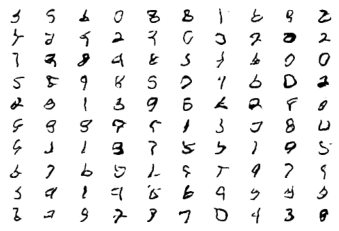

In [63]:
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = client_models[0]['g'].predict(latent_points)
# X = central_g.predict(latent_points)

show_plot(X, 10)

In [64]:
for idx, model in enumerate(client_models):
    g = model['g']
    d = model['d']
    gan = model['gan']
    g.save('2gen'+str(idx))
    d.save('2disc'+str(idx))
    gan.save('2gan'+str(idx))
g = central_g
d = central_d
g.save('2gen_central')
d.save('2disc_central')

INFO:tensorflow:Assets written to: 2gen0/assets
INFO:tensorflow:Assets written to: 2disc0/assets
INFO:tensorflow:Assets written to: 2gan0/assets
INFO:tensorflow:Assets written to: 2gen1/assets
INFO:tensorflow:Assets written to: 2disc1/assets
INFO:tensorflow:Assets written to: 2gan1/assets
INFO:tensorflow:Assets written to: 2gen2/assets
INFO:tensorflow:Assets written to: 2disc2/assets
INFO:tensorflow:Assets written to: 2gan2/assets
INFO:tensorflow:Assets written to: 2gen3/assets
INFO:tensorflow:Assets written to: 2disc3/assets
INFO:tensorflow:Assets written to: 2gan3/assets
INFO:tensorflow:Assets written to: 2gen4/assets
INFO:tensorflow:Assets written to: 2disc4/assets
INFO:tensorflow:Assets written to: 2gan4/assets
INFO:tensorflow:Assets written to: 2gen_central/assets
INFO:tensorflow:Assets written to: 2disc_central/assets
